# LSTM for Time Series Prediction


In this notebook, we will demonstrate how to use Long Short-Term Memory (LSTM) neural networks for time series prediction.

This notebook, when executed, will:

1. Load and visualize the Airline Passengers dataset.
2. Preprocess the data by normalizing it and splitting it into training and testing sets.
3. Create input-output pairs for training/testing with a certain timestep.
4. Build an LSTM model and train it on the prepared data.
5. Evaluate the model by computing its RMSE on the training and testing data.
6. Visualize the true data vs. the model's predictions.

In [2]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

## Data Preparation


First, let's load and visualize the Airline Passengers dataset.

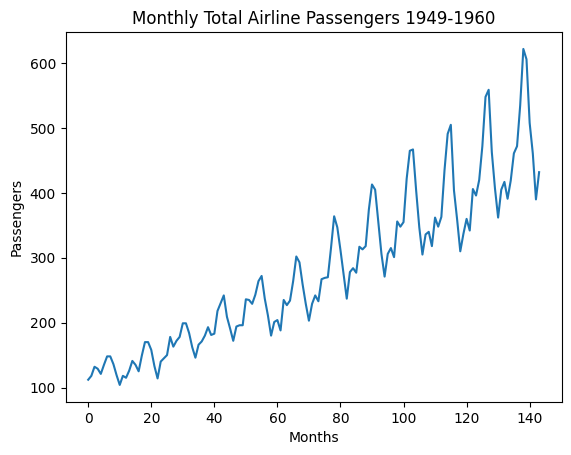

In [3]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
dataframe = pd.read_csv(url, usecols=[1], engine='python')
plt.plot(dataframe)
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("Monthly Total Airline Passengers 1949-1960")
plt.show()

## Data Preprocessing

Before training an LSTM model, we need to preprocess our data. This involves scaling our data and converting it into the right shape.

In [4]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe.values.astype('float32'))

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


## Create Dataset Matrix

This utility function creates a dataset matrix. Given data, and choosing a certain time step, it will create input-output pairs.

In [5]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1, choosing a timestep of 3
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## LSTM Model Building & Training

In [6]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)



Epoch 1/100

92/92 - 5s - loss: 0.0725 - 5s/epoch - 58ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0300 - 390ms/epoch - 4ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0211 - 475ms/epoch - 5ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0182 - 297ms/epoch - 3ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0157 - 278ms/epoch - 3ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0137 - 267ms/epoch - 3ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0115 - 294ms/epoch - 3ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0097 - 278ms/epoch - 3ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0079 - 302ms/epoch - 3ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0066 - 277ms/epoch - 3ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0058 - 294ms/epoch - 3ms/step
Epoch 12/100
92/92 - 1s - loss: 0.0050 - 541ms/epoch - 6ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0048 - 379ms/epoch - 4ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0047 - 293ms/epoch - 3ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0044 - 324ms/epoch - 4ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0044 - 316ms/e

## Model Evaluation

In [7]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
trainScore = np.sqrt(((trainPredict-y_train)**2).mean())
testScore = np.sqrt(((testPredict-y_test)**2).mean())
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 4ms/step
Train Score: 94.98 RMSE
Test Score: 95.56 RMSE


# Visualizing Predictions

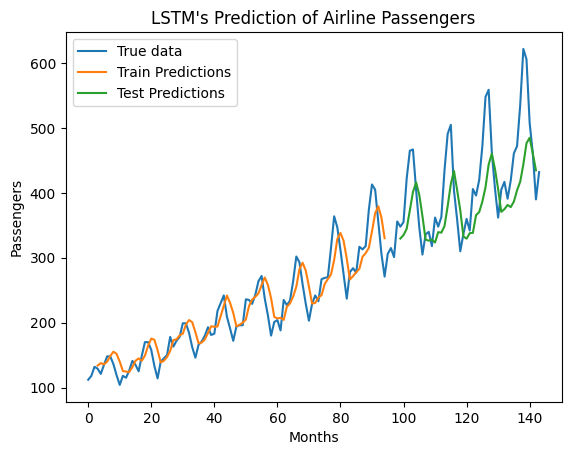

In [8]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label="True data")
plt.plot(trainPredictPlot, label="Train Predictions")
plt.plot(testPredictPlot, label="Test Predictions")
plt.xlabel("Months")
plt.ylabel("Passengers")
plt.title("LSTM's Prediction of Airline Passengers")
plt.legend()
plt.show()